In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import random

In [2]:
filename = "020/profiles.csv"
profiles = pd.read_csv(filename, sep='\t', index_col=0)
filename2 = "020/labor.csv"
labor = pd.read_csv(filename2, sep='\t', index_col=0)

In [3]:
labor.loc[labor['smoker'] == 'yes', 'smoker']='Y'
labor.loc[labor['smoker'] == 'no', 'smoker']='N'
labor['weight']=labor['weight'].apply(abs)
labor = labor.drop_duplicates()
labor = labor.reset_index(drop = True)

In [4]:
labor.loc[labor['smoker'] == 'Y', 'smoker']=1
labor.loc[labor['smoker'] == 'N', 'smoker']=0
labor['smoker'] = labor['smoker'].astype(float, errors = 'raise')

## numerical data

In [5]:
labor.head()

,er-cv,name,indicator,leukocyty,weight,ssn,relationship,etytr,smoker,erytrocyty,trombocyty,hemoglobin,ast,alp,alt,hematokrit,hbver
0,43.09887,Devin Diaz,1.0,4.47526,65.57593,597-97-9078,single,5.96219,0.0,6.20665,5.71427,5.06667,57.92930,57.60257,5.12934,7.11081,6.32708
1,32.51734,Theodore Morris,1.0,4.41339,58.47779,100-19-5038,divoced,5.44840,0.0,5.58217,6.29619,6.90945,61.47846,83.38342,10.59365,8.52324,9.06429
2,54.39106,Ashley Mccormick,1.0,4.71119,37.58396,241-30-2551,widowed,6.75478,1.0,6.36030,6.67129,4.08668,59.37033,31.60935,10.72644,8.41874,7.11435
3,45.79943,Brent Howard,1.0,5.38079,88.06628,667-52-4116,married,6.33099,0.0,5.45784,6.24957,5.57164,50.31551,75.29715,9.26557,4.69702,7.00724
4,48.81261,Paul Jordan,0.0,4.72469,44.59816,368-59-5827,divoced,6.62153,0.0,6.36262,6.44608,6.49617,50.44424,84.90135,9.31196,6.31221,8.54503


# 1 a

Missing values: 
 - labor_dropna -> vymazane vsetky riadky s nan hodnotou
 - labor -> nan hodnoty v labor su dalej vyplnene podla funkcie my_fill_na (vyplnene priemerom)

In [6]:
def my_fill_na(arg1,ind):
    labor.loc[labor['indicator'] == ind , arg1] = labor.loc[labor['indicator'] == ind , arg1].fillna(
    (labor.loc[labor['indicator'] == ind , arg1].mean()))
    
def drop_na(df):
    return df.copy().dropna()

def use_my_fill_na(atributes):
    for atribute in atributes:
        my_fill_na(atribute, 0)
        my_fill_na(atribute, 1)

In [7]:
drop_labor = drop_na(labor)
use_my_fill_na(['er-cv', 'leukocyty', 'etytr', 'erytrocyty', 'trombocyty', 'hemoglobin', 'ast', 'alt', 'alp', 'hematokrit', 'hbver'])

# 1 b

In [8]:
def detect_outlier(atr):
    lower = atr.quantile(0.25) - 1.5
    upper = atr.quantile(0.75) + 1.5
    
    return atr[(atr > upper) | (atr < lower)]

def detect_upper_lower_outliers(atr):
    lower = atr.quantile(0.25) - 1.5
    upper = atr.quantile(0.75) + 1.5
    
    return atr[(atr > upper)], atr[(atr < lower)]

# Tato funkcia najde vrchnych a spodnych outlierov a vyplni ich nahodnou hodnotou medzi minimom bez outlierov a 10 spodnych % pripadne maximom bez outlierov a 10 vrchnych %
def fill_outliers(df, atr):
    df.loc[detect_upper_lower_outliers(df[atr])[0].index, [atr]] = random.uniform(df.drop(detect_upper_lower_outliers(df[atr])[0].index)[atr].quantile(0.90), df.drop(detect_upper_lower_outliers(df[atr])[0].index)[atr].max())
    df.loc[detect_upper_lower_outliers(df[atr])[1].index, [atr]] = random.uniform(df.drop(detect_upper_lower_outliers(df[atr])[1].index)[atr].min(), df.drop(detect_upper_lower_outliers(df[atr])[1].index)[atr].quantile(0.10))
    df[atr]
    
def handle_outlier(df, atributes, handle_type='fill'):
    result = df.copy()
    if handle_type == 'fill':
        for atribute in atributes:
            fill_outliers(result, atribute)
    elif handle_type == 'drop':
        for atribute in atributes:
            result.drop(detect_outlier(result[atribute]).index, inplace=True)
    else:
        print("incorrect handle_type")
    return result

In [9]:
fill_labor = handle_outlier(labor, ['er-cv', 'leukocyty', 'etytr', 'erytrocyty', 'trombocyty', 'hemoglobin', 'ast', 'alt', 'alp', 'hematokrit', 'hbver'], 'fill')
drop_labor = handle_outlier(labor, ['er-cv', 'leukocyty', 'etytr', 'erytrocyty', 'trombocyty', 'hemoglobin', 'ast', 'alt', 'alp', 'hematokrit', 'hbver'], 'drop')

In [10]:
# decision
labor = fill_labor

# 2 a

In [11]:
split_by = 0.75
labor_train = labor.sample(frac=split_by,random_state=200)
labor_test = labor
labor_test = pd.merge(labor_test,labor_train,indicator = True, how = 'outer').query('_merge=="left_only"').drop('_merge', axis = 1)
labor_train=labor_train.drop(['name','relationship','ssn'],axis=1)

# 2 b

In [12]:
atributes = ['er-cv', 'leukocyty', 'etytr', 'erytrocyty', 'trombocyty', 'hemoglobin', 'ast', 'alt', 'alp', 'hematokrit', 'hbver']

In [13]:
def my_fit(df, scaler, atributes):
    return scaler.fit_transform(df.loc[:, atributes])

<AxesSubplot:ylabel='Count'>

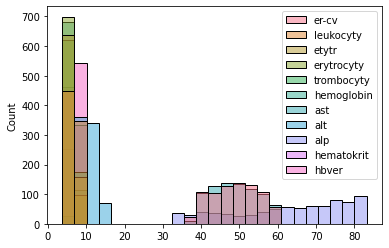

In [14]:
sns.histplot(drop_labor.loc[:, atributes])

<AxesSubplot:ylabel='Count'>

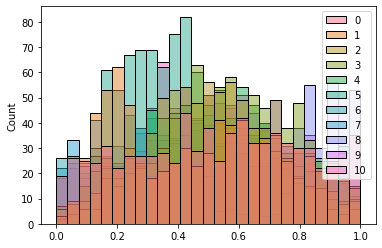

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(drop_labor.loc[:, atributes])
sns.histplot(scaled)

<AxesSubplot:ylabel='Count'>

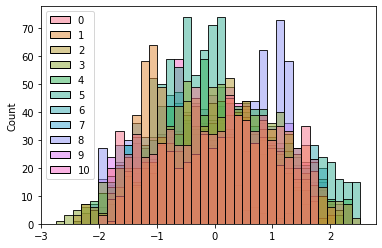

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(drop_labor.loc[:, atributes])
sns.histplot(scaled)

<AxesSubplot:ylabel='Count'>

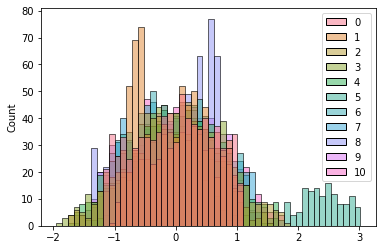

In [17]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled = scaler.fit_transform(drop_labor.loc[:, atributes])
sns.histplot(scaled)

<AxesSubplot:ylabel='Count'>

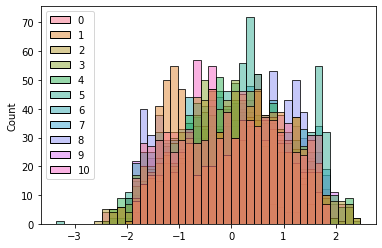

In [18]:
from sklearn.preprocessing import PowerTransformer
power = PowerTransformer(method='yeo-johnson', standardize=True)
trans = power.fit_transform(drop_labor.loc[:, atributes])
sns.histplot(trans)

<AxesSubplot:ylabel='Count'>

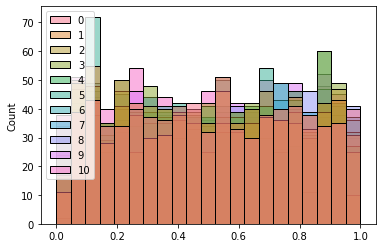

In [19]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(n_quantiles=10, random_state=0)
trans = qt.fit_transform(drop_labor.loc[:, atributes])
sns.histplot(trans)

<AxesSubplot:ylabel='Count'>

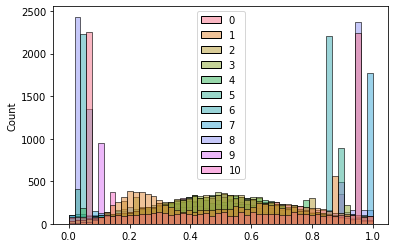

In [20]:
# decision
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
labor = my_fit(labor, scaler, ['er-cv', 'leukocyty', 'etytr', 'erytrocyty', 'trombocyty', 'hemoglobin', 'ast', 'alt', 'alp', 'hematokrit', 'hbver'])
sns.histplot(labor)

In [21]:
# data cleaning (2.1)
def run_data_clean(atributes):
    use_my_fill_na(atributes)
    fill_labor = handle_outlier(labor, atributes, 'fill')
    
# preprocessing realisation (2.2)
def run_preprocessing_realisation(df):
    split_by = 0.75
    df_train = df.sample(frac=split_by,random_state=200)
    df_train.sort_index()
    df_test = df
    df_test = pd.merge(df_test,df_train,indicator = True, how = 'outer').query('_merge=="left_only"').drop('_merge', axis = 1)
    return df_train, df_test

def transformation(df, atributes):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    return my_fit(df, scaler, atributes)
    


<AxesSubplot:ylabel='Count'>

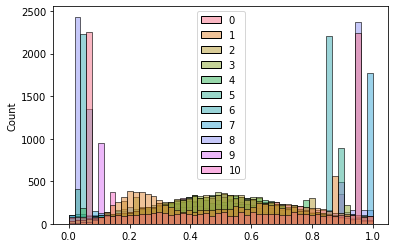

In [22]:
sns.histplot(labor)